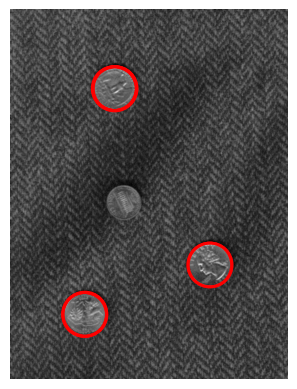

In [ ]:
import numpy as np
from PIL import Image
from scipy import ndimage
import matplotlib.pyplot as plt

def load_image(image_path):
    with Image.open(image_path) as img:
        img = img.convert('L')
        return np.array(img)

""" 
这里我实现Hough变换前先实现canny边缘检测，这样hough变换的效果会更好
"""

class Canny:
    def __init__(self,image : np.ndarray) -> None:
        self.image = image
    
    # 计算梯度幅值和方向
    def Gradient(self):
        # 这里要使用高斯模糊来达到更好的效果，就不自己实现了，因为前面已经实现过了
        img = ndimage.gaussian_filter(self.image, sigma=1.4)
        
        img = img.astype(np.float64) # 讲uint8类型转换为浮点防止溢出
        Sx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype=np.float64)

        Sy = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], dtype=np.float64)

        Gx = ndimage.convolve(img, Sx)
        Gy = ndimage.convolve(img, Sy)

        G = np.hypot(Gx, Gy) #这里不能直接使用np.sqrt(Gx**2 + Gy**2)，因为可能会溢出
        theta = np.arctan2(Gy, Gx)
        theta = np.rad2deg(theta)
        theta[theta < 0] += 180

        return G, theta

    # 非极大值抑制
    def Nms(self,G,angle):
        M, N = G.shape
        Z = np.zeros((M,N), dtype=np.float64)

        for i in range(1,M-1):
            for j in range(1,N-1):
                try:
                    q = 255
                    r = 255

                    #angle 0
                    if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
                        q = G[i, j+1]
                        r = G[i, j-1]
                    #angle 45
                    elif (22.5 <= angle[i,j] < 67.5):
                        q = G[i+1, j-1]
                        r = G[i-1, j+1]
                    #angle 90
                    elif (67.5 <= angle[i,j] < 112.5):
                        q = G[i+1, j]
                        r = G[i-1, j]
                    #angle 135
                    elif (112.5 <= angle[i,j] < 157.5):
                        q = G[i-1, j-1]
                        r = G[i+1, j+1]

                    if (G[i,j] >= q) and (G[i,j] >= r):
                        Z[i,j] = G[i,j]
                    else:
                        Z[i,j] = 0

                except IndexError as e:
                    pass
        return Z
    
    # 双阈值和滞后阈值处理
    def double_threshold_hysteresis(self,Z, lowRatio=0.05, highRatio=0.15):
        M, N = Z.shape
        res = np.zeros((M, N), dtype=np.uint8)

        highThreshold = Z.max() * highRatio
        lowThreshold = highThreshold * lowRatio

        strong_i, strong_j = np.where(Z >= highThreshold)
        weak_i, weak_j = np.where((Z >= lowThreshold) & (Z < highThreshold))

        res[strong_i, strong_j] = 255
        res[weak_i, weak_j] = 50

        stack = list(zip(strong_i, strong_j))
        while stack:
            i, j = stack.pop()
            for di in [-1, 0, 1]:
                for dj in [-1, 0, 1]:
                    ni, nj = i + di, j + dj
                    if 0 <= ni < M and 0 <= nj < N:
                        if res[ni, nj] == 50:
                            res[ni, nj] = 255
                            stack.append((ni, nj))

        res[res != 255] = 0
        return res

# 使用Hough变换检测存在圆形的位置，并抑制不是圆形的位置
def isolate_circle_edges(edges, radius, theta_step=1, vote_threshold=0.5):
    h, w = edges.shape
    acc = np.zeros((h, w), dtype=np.uint64)
    y_idxs, x_idxs = np.nonzero(edges)
    thetas = np.deg2rad(np.arange(0, 360, theta_step))

    for x, y in zip(x_idxs, y_idxs):
        for theta in thetas:
            a = int(x - radius * np.cos(theta))
            b = int(y - radius * np.sin(theta))
            if 0 <= a < w and 0 <= b < h:
                acc[b, a] += 1

    # 阈值
    threshold = vote_threshold * acc.max()

    acc[acc < threshold] = 0

    return acc.astype(np.uint8)

img = load_image("硬币原图.jpg")
canny = Canny(img)
G, theta = canny.Gradient()
nms_img = canny.Nms(G, theta)
after_process_img = canny.double_threshold_hysteresis(nms_img)

result = isolate_circle_edges(after_process_img, radius=42, theta_step=1, vote_threshold=0.55)

# 使用plt可视化结果
plt.imshow(img, cmap='gray')
ax = plt.gca()  # get current Axes object
y_idxs, x_idxs = np.nonzero(result)
for x, y in zip(x_idxs, y_idxs):
    circle = plt.Circle((x, y), 42, color='r', fill=False, linewidth=2)
    ax.add_patch(circle)
ax.axis('off')

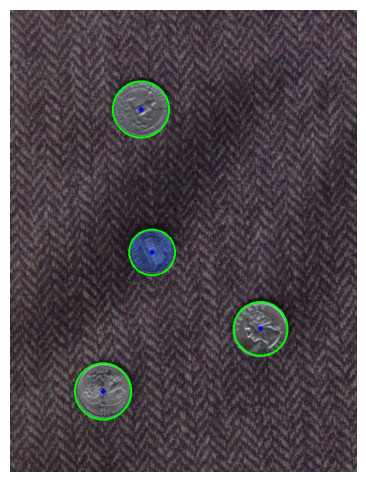

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

path = "硬币原图.jpg"

# 这里要注意不能使用 cv2.imread 读取中文路径的图片
img = cv2.imdecode(np.fromfile(path, dtype=np.uint8), cv2.IMREAD_COLOR)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

gray = cv2.GaussianBlur(gray, (9, 9), 2)

circles = cv2.HoughCircles(
    gray,
    cv2.HOUGH_GRADIENT,
    dp=1.2,
    minDist=50,
    param1=100,
    param2=30,
    minRadius=0,
    maxRadius=0,
)

if circles is not None:
    circles = np.uint16(np.around(circles))
    for i in circles[0, :]:
        cv2.circle(img, (i[0], i[1]), i[2], (0, 255, 0), 2)
        cv2.circle(img, (i[0], i[1]), 2, (0, 0, 255), 3)

plt.figure(figsize=(6, 6))
plt.imshow(img, cmap="gray")
plt.axis("off")
plt.show()